In [1]:
%load_ext autoreload
%autoreload 2
%cd ../../

/mainfs/home/jd5u19/progressive-tradeoff


In [2]:

import numpy as np
import json
from sklearn.metrics import confusion_matrix
from main.utils.get_data import get_dataset

from main.utils.analysis_utils import plot_macs_vs_acc,entropy

import matplotlib.pyplot as plt
height = 8
width = height*1.6
plt.rcParams["figure.figsize"] = (width,height)
plt.style.use('seaborn-colorblind')

# import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

height = 16
width = height*1.6
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["figure.figsize"] = (width,height)
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['xtick.major.width'] = 1.6
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = "black"
plt.rcParams['axes.linewidth'] = 1.6
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.size'] = 25

def get_model_params(directory):
    model_param_file = open(directory + '/model_params.json')
    model_params = json.load(model_param_file)
    if 'loss' not in model_params.keys():
        model_params['loss'] = 'cross-entropy'
    return model_params
def get_label(labels,label):
    if label in labels:
        label = label+'_'+str(2)
        for i in range(3,10):
            if label in labels:
                label = label+'_'+str(i)
            else:
                break
    labels.append(label)
    return labels,label

def make_data(id_set,ood_set):
    y_1,y_2 = np.zeros(len(id_set)),np.ones(len(ood_set))
    return(np.concatenate([id_set,ood_set]),np.concatenate([y_1,y_2]))

n_bins = 100

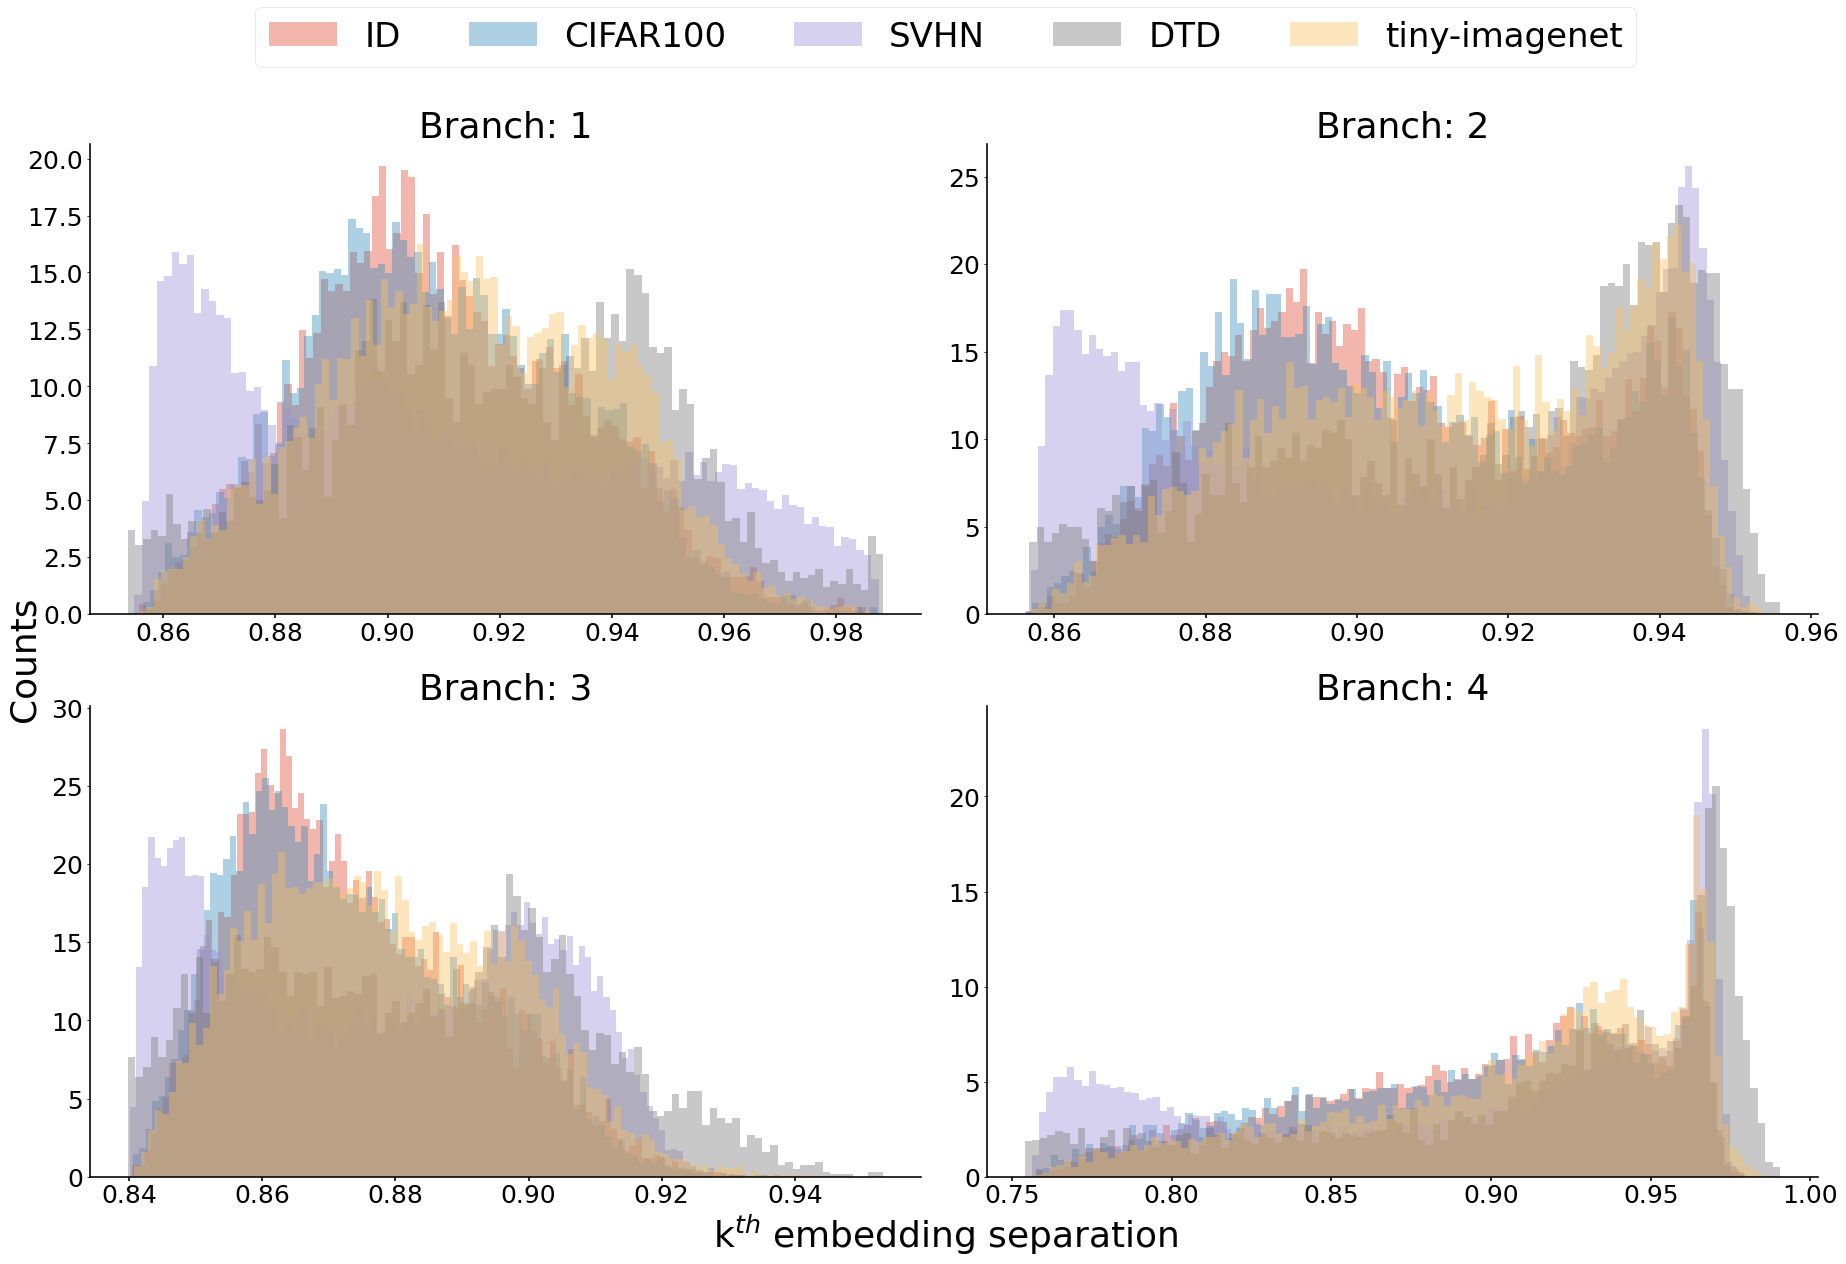

In [3]:
#Taking mean value

model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d50/sgd-supcon-long/'

knn_id = 'CIFAR10_train'
knn_ood_control = 'CIFAR10_test'
knn_ood_tests = ['CIFAR100_test','SVHN_test','DTD_test','tiny-imagenet_test']

id = np.load(model_directory+'/knn_ood/train_'+knn_id+'/test_'+knn_ood_control+'/all_k_distances.npy')[:,:,-1]
n_branches = id.shape[1]

fig, axes = plt.subplots(2, int(n_branches/2))
id_plotted = np.zeros(n_branches,dtype=bool)
red_line_heights = np.zeros(n_branches)
for ood_test in knn_ood_tests:
    ood = np.load(model_directory+'/knn_ood/train_'+knn_id+'/test_'+ood_test+'/all_k_distances.npy')[:,:,-1]
    for branch,ax in enumerate(axes.flatten()):
        id_branch = id[:,branch]
        ood_branch = ood[:,branch]
        ax.set_title('Branch: '+ str(branch+1))
        if id_plotted[branch] == False:
            n,bins,_ = ax.hist(id_branch,bins=n_bins,label='ID',alpha=0.4,density=True)
            id_plotted[branch] = True
        n,bins,_ = ax.hist(ood_branch,bins=n_bins,label=ood_test.split('_')[0],alpha=0.4,density=True)

# fig.text(0.5, 0.95, ('Embedding separation with OOD data'), ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(0.0, 0.5, 'Counts', ha='center', va='center', rotation='vertical',fontsize=36)
fig.text(0.5, 0.0, 'k$^{th}$ embedding separation', ha='center', va='center', rotation='horizontal',fontsize=36)

h, l = axes.flatten()[-1].get_legend_handles_labels()
legend = fig.legend(h,l,loc='center',bbox_to_anchor=(0.5,1.04),ncol=5,fontsize=34)
plt.setp(legend.get_title(), multialignment='center')
plt.tight_layout()
plt.savefig('main/figures/ood_dists.pdf',bbox_inches='tight')
plt.show()

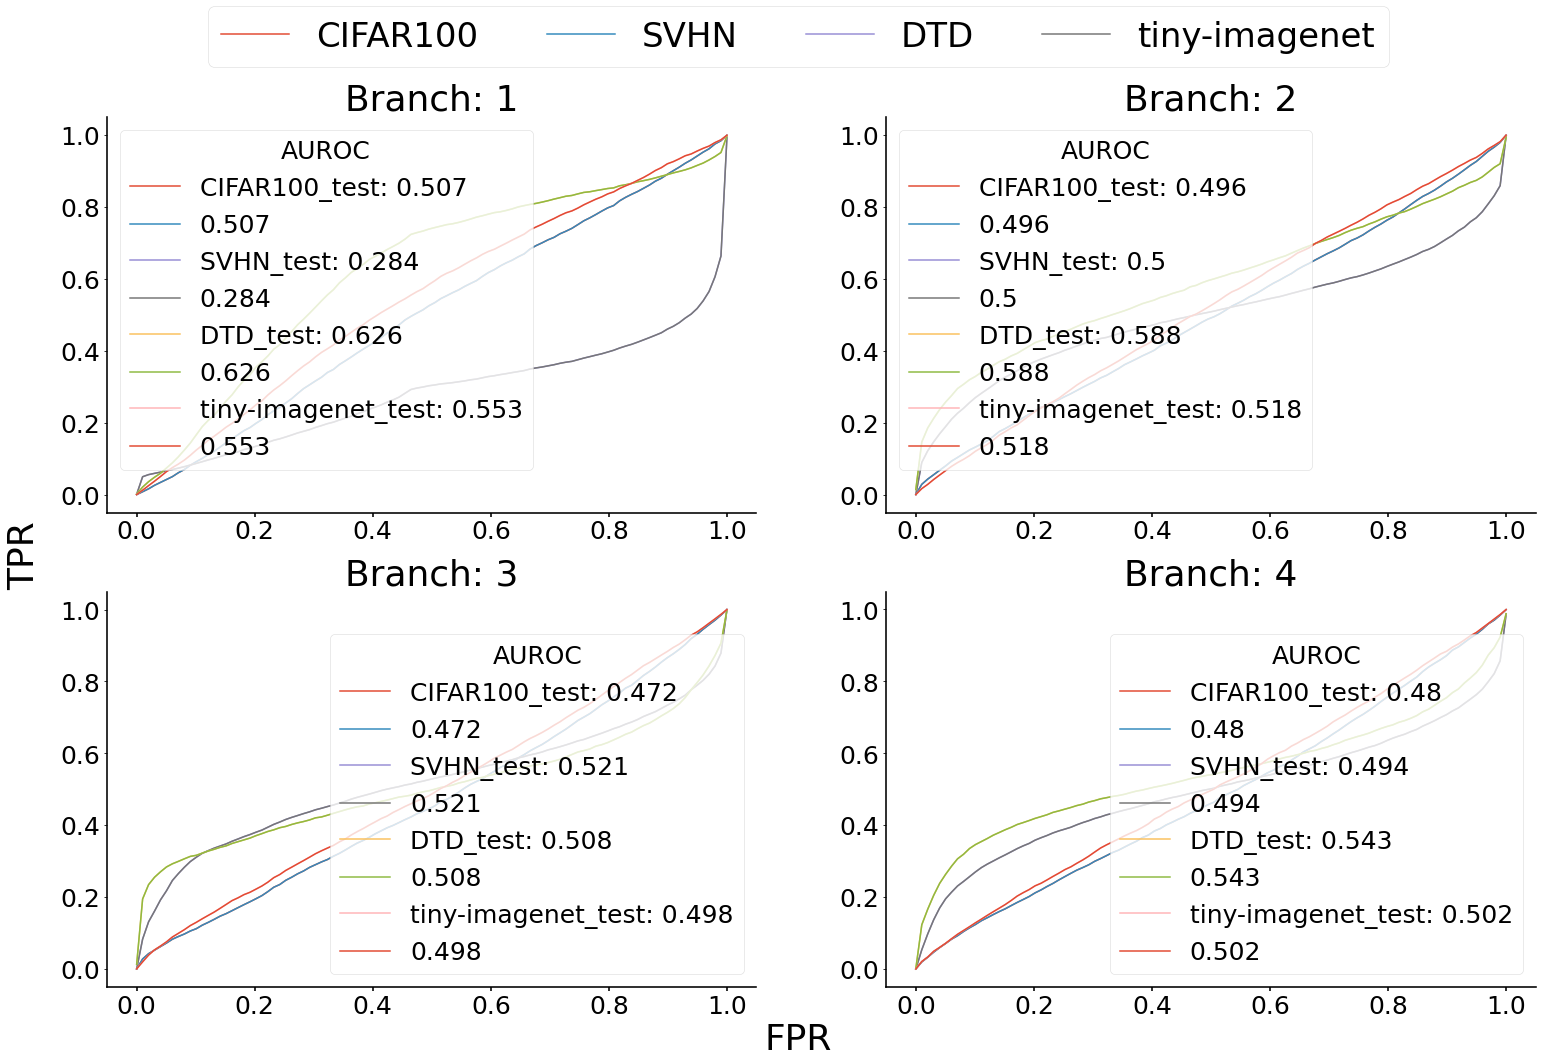

In [4]:
#Taking mean value

model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d50/sgd-supcon-long/'

knn_id = 'CIFAR10_train'
knn_ood_control = 'CIFAR10_test'
knn_ood_tests = ['CIFAR100_test','SVHN_test','DTD_test','tiny-imagenet_test']
n_thresh=100
id = np.mean(np.load(model_directory+'/knn_ood/train_'+knn_id+'/test_'+knn_ood_control+'/all_k_distances.npy'),axis=-1)
n_branches = id.shape[1]
thresholds = np.linspace(0,100,n_thresh)
fig, axes = plt.subplots(2, int(n_branches/2))
for ood_test in knn_ood_tests:
    ood = np.mean(np.load(model_directory+'/knn_ood/train_'+knn_id+'/test_'+ood_test+'/all_k_distances.npy'),axis=-1)
    for branch,ax in enumerate(axes.flatten()):
        id_branch = id[:,branch]
        ood_branch = ood[:,branch]
        TPR = np.zeros(n_thresh)
        FPR = np.zeros(n_thresh)
        decision_boundaries = np.zeros(n_thresh)
        for thresh_idx,thresh in enumerate(thresholds[::-1]):
            threshold = np.percentile(id_branch,thresh)
            x,y = make_data(id_branch,ood_branch)
            preds = np.array(x>threshold,dtype=int)
            conf_mat = confusion_matrix(y,preds)
            tp = conf_mat[1,1]
            fp = conf_mat[0,1]
            tn = conf_mat[0,0]
            fn = conf_mat[1,0]

            TPR[thresh_idx] = tp/(fn+tp)
            FPR[thresh_idx] = fp/(tn+fp)
        
        AUROC = np.trapz(TPR,FPR)
        ax.set_title('Branch: '+str(branch+1))
        ax.plot(FPR,TPR,label=(ood_test+': '+str(round(AUROC,3))))
        ax.plot(FPR,TPR,label=(str(round(AUROC,3))))
        ax.legend(title='AUROC')
    
        # ax.grid(which='major',color='grey', alpha=0.3,linestyle='--', linewidth=1.5)

h, l = axes.flatten()[-1].get_legend_handles_labels()
l = ['CIFAR100','SVHN','DTD','tiny-imagenet']
legend = fig.legend(h,l,loc='center',bbox_to_anchor=(0.5,0.95),ncol=5,fontsize=34)
plt.setp(legend.get_title(), multialignment='center')

# fig.text(0.5, 0.95, ('OOD detection ROC'), ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(0.08, 0.5, 'TPR', ha='center', va='center', rotation='vertical',fontsize=36)
fig.text(0.5, 0.08, 'FPR', ha='center', va='center', rotation='horizontal',fontsize=36)
# plt.legend()
plt.savefig('main/figures/ood_roc_no_AUROC.pdf',bbox_inches='tight')
plt.show()

In [3]:
def get_AUROC(directory,knn_ood_tests,n_thresh=100,knn_id='CIFAR10',knn_ood_control='CIFAR10'):
    id = np.mean(np.load(directory+'/knn_ood/train_'+knn_id+'_train/test_'+knn_ood_control+'_test/all_k_distances.npy'),axis=-1)
    n_branches = id.shape[1]
    areas = np.zeros((len(knn_ood_tests),n_branches))
    thresholds = np.linspace(0,100,n_thresh)
    for test_idx,ood_test in enumerate(knn_ood_tests):
        ood = np.mean(np.load(directory+'/knn_ood/train_'+knn_id+'_train/test_'+ood_test+'_test/all_k_distances.npy'),axis=-1)
        for branch in range(n_branches):
            id_branch = id[:,branch]
            ood_branch = ood[:,branch]
            TPR = np.zeros(n_thresh)
            FPR = np.zeros(n_thresh)
            for thresh_idx,thresh in enumerate(thresholds[::-1]):
                threshold = np.percentile(id_branch,thresh)
                x,y = make_data(id_branch,ood_branch)
                preds = np.array(x>threshold,dtype=int)
                conf_mat = confusion_matrix(y,preds)
                tp = conf_mat[1,1]
                fp = conf_mat[0,1]
                tn = conf_mat[0,0]
                fn = conf_mat[1,0]

                TPR[thresh_idx] = tp/(fn+tp)
                FPR[thresh_idx] = fp/(tn+fp)
            
            areas[test_idx,branch] = np.trapz(TPR,FPR)
    return areas

In [4]:
directories = ['trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch/',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_1/',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_2/',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_3/',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_4/']
               
knn_ood_tests = ['CIFAR10','SVHN','DTD','tiny-imagenet']

AUROC_curves = list()

for directory in directories:
    AUROC_curves.append(get_AUROC(directory,knn_ood_tests,knn_id='CIFAR100',knn_ood_control='CIFAR100'))

all_curves = np.stack(AUROC_curves,axis=0)

np.save(directories[0]+'/knn_ood/AUROC_ood.npy',all_curves) 

In [5]:
directory = 'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch/'
all_curves = np.load(directory+'/knn_ood/AUROC_ood.npy')

knn_ood_tests = ['CIFAR10','SVHN','DTD','tiny-imagenet']
n_branches = 4 

mean_area = np.mean(all_curves,axis=0)
std_area = np.std(all_curves,axis=0)

for test_idx,test in enumerate(knn_ood_tests):
    print('Data:',test)
    for branch in range(n_branches):
        print('Branch:',branch+1,np.round(mean_area[test_idx,branch],2),'+-',np.round(std_area[test_idx,branch],2))

Data: CIFAR10
Branch: 1 0.59 +- 0.0
Branch: 2 0.59 +- 0.01
Branch: 3 0.62 +- 0.02
Branch: 4 0.75 +- 0.01
Data: SVHN
Branch: 1 0.74 +- 0.05
Branch: 2 0.81 +- 0.03
Branch: 3 0.91 +- 0.02
Branch: 4 0.81 +- 0.02
Data: DTD
Branch: 1 0.48 +- 0.02
Branch: 2 0.8 +- 0.03
Branch: 3 0.9 +- 0.01
Branch: 4 0.85 +- 0.01
Data: tiny-imagenet
Branch: 1 0.55 +- 0.02
Branch: 2 0.76 +- 0.03
Branch: 3 0.81 +- 0.01
Branch: 4 0.83 +- 0.01


In [9]:
#Taking mean value

# Get ID exits, get knn exits at same time, treat as misclassification if knn exit/use branch accuracies to determine if valid exit
# Then get knn exits, don't use accuracy, but use the exits for power usage
# Additional option to look at ood outputs to see if it meets exit criteria: these are in OOD_analysis.npy 

def log_spacing(value,n_thresh):
    diff = 1-value
    logs = np.logspace(-2,0,n_thresh)
    return logs*diff + value  

def run_ood_inference(model_directory,train_dataset,ood_dataset,n_thresh=100,knn_percentile=0.95,detect_ood=True,adaptive=False):
    func_outputs = dict()
    name = model_directory.split('/')[3] + ' -- ' + model_directory.split('/')[4]

    id_outputs = np.load(model_directory+'/outputs.npy')
    n_branches = id_outputs.shape[1]
    id_labels = np.load(model_directory+'/labels.npy')

    powers = np.load(model_directory+'/power_usage.npy')

    id_knn = np.load(model_directory+'/../knn_ood/train_'+train_dataset+'_train/test_'+train_dataset+'_test/all_k_distances.npy')
    ood_knn = np.load(model_directory+'/../knn_ood/train_'+train_dataset+'_train/test_'+ood_dataset+'_test/all_k_distances.npy')

    branch_predictions = np.argmax(id_outputs,axis=2)

    n_id_inputs = branch_predictions.shape[0]
    n_ood_inputs = ood_knn.shape[0]

    n_ood_inputs = min(n_ood_inputs,n_id_inputs)

    ood_labels = np.full(n_ood_inputs,-1)
    all_labels = np.concatenate([id_labels,ood_labels])

    id_entropies = np.zeros((n_id_inputs,n_branches))
    for input_idx in range(n_id_inputs):
        for branch_idx in range(n_branches):
            id_entropies[input_idx,branch_idx] = entropy(id_outputs[input_idx,branch_idx,:])
    
    id_exits = np.zeros((n_thresh,n_id_inputs,n_branches))
    id_predictions = np.zeros((n_thresh,n_id_inputs))

    ood_exits = np.zeros((n_thresh,n_ood_inputs,n_branches))
    ood_predictions = np.zeros((n_thresh,n_ood_inputs))

    power_usage = np.zeros(n_thresh)

    max_entropy = np.log(id_outputs.shape[2])  
    thresholds = np.linspace(max_entropy,0,n_thresh)

    knn_thresholds = np.zeros((n_branches,n_thresh))
    for branch in range(n_branches):
        id_branch = id_knn[:,branch,-1]
        knn_thresholds[branch,:] = np.percentile(id_branch,knn_percentile*100)
        if adaptive == True: 
            # adaptive_index = int(n_thresh/2)
            # percentiles=np.linspace(knn_percentile,1,n_thresh-(adaptive_index+1))
            percentiles=log_spacing(knn_percentile,n_thresh)
            for p_idx,percentile in enumerate(percentiles):
                knn_thresh = np.percentile(id_branch,percentile*100)
                # knn_thresholds[branch,p_idx+adaptive_index+1] = knn_thresh
                knn_thresholds[branch,p_idx] = knn_thresh

    # print(knn_thresholds)
    
    for thresh_idx,threshold in enumerate(thresholds):
        #get ID outputs w/ knn 
        for inp_idx in range(n_id_inputs):
            early_exit = False
            for branch_idx,branch_entropy in enumerate(id_entropies[inp_idx,:]):
                if id_knn[inp_idx,branch_idx,-1] > knn_thresholds[branch_idx,thresh_idx]:
                    id_exits[thresh_idx,inp_idx,branch_idx] = 1
                    id_predictions[thresh_idx,inp_idx] = -1
                    early_exit=True
                    break
                if branch_entropy < threshold:
                    id_exits[thresh_idx,inp_idx,branch_idx] = 1
                    id_predictions[thresh_idx,inp_idx] = branch_predictions[inp_idx,branch_idx] 
                    early_exit=True
                    break
            if early_exit == False:
                id_exits[thresh_idx,inp_idx,(n_branches-1)] = 1
                id_predictions[thresh_idx,inp_idx] = branch_predictions[inp_idx,(n_branches-1)]

        #get OOD knn outputs w/ entropy
        for inp_idx in range(n_ood_inputs):
            if not detect_ood:
                ood_exits[:,:,(n_branches-1)] = 1
                ood_predictions[:,:] = -2
                break
            early_exit = False
            for branch_idx,knn_distance in enumerate(ood_knn[inp_idx,:,-1]):
                if knn_distance > knn_thresholds[branch_idx,thresh_idx]:
                    ood_exits[thresh_idx,inp_idx,branch_idx] = 1
                    ood_predictions[thresh_idx,inp_idx] = -1
                    early_exit=True
                    break
            if early_exit == False:
                ood_exits[thresh_idx,inp_idx,(n_branches-1)] = 1
                ood_predictions[thresh_idx,inp_idx] = -2

        all_exits = np.concatenate([id_exits,ood_exits],axis=1) 
        power_usage[thresh_idx] = np.dot(np.sum(all_exits[thresh_idx,:],axis=0),powers)
        all_predictions = np.concatenate([id_predictions,ood_predictions],axis=1) 

    ood_accuracy = np.zeros(n_thresh)
    id_accuracy = np.zeros(n_thresh)
    all_accuracy = np.zeros(n_thresh)
    for thresh in range(n_thresh):
        id_accuracy[thresh] = np.mean(id_predictions[thresh,:] == id_labels) 
        ood_accuracy[thresh] = np.mean(ood_predictions[thresh,:] == ood_labels) 
        all_accuracy[thresh] = np.mean(all_predictions[thresh,:] == all_labels) 
    
    func_outputs['all_predictions'] = all_predictions
    func_outputs['power_usage'] = power_usage/len(all_labels)
    func_outputs['all_labels'] = all_labels
    func_outputs['all_exits'] = all_exits
    func_outputs['id_predictions'] = id_predictions
    func_outputs['id_labels'] = id_labels
    func_outputs['ood_labels'] = ood_labels
    func_outputs['id_accuracy'] = id_accuracy
    func_outputs['ood_accuracy'] = ood_accuracy
    func_outputs['all_accuracy'] = all_accuracy
    func_outputs['n_id_samples'] = n_id_inputs
    func_outputs['n_ood_samples'] = n_ood_inputs


    return func_outputs

def plot_ood_power(ax,model_directory,data,ood_data,n_thresh,percentile,detect_ood=True,adaptive=False):
    if detect_ood==False:
        label = 'None'
    else:
        label = str(percentile)
        
    func_out = run_ood_inference(model_directory,data,ood_data,n_thresh=n_thresh,knn_percentile=percentile,detect_ood=detect_ood,adaptive=adaptive)
    ax.plot(func_out['power_usage'],func_out['id_accuracy'],label=label)
    standard_error = 1/np.sqrt(func_out['n_id_samples'])
    ax.fill_between(func_out['power_usage'],func_out['id_accuracy']-standard_error,func_out['id_accuracy']+standard_error,alpha=0.3)

def plot_improvement_power(ax,model_directory,data,ood_data,n_thresh,percentile,detect_ood=True,adaptive=False):
    base_value_dict = run_ood_inference(model_directory,data,ood_data,n_thresh=n_thresh,knn_percentile=1.0,detect_ood=False,adaptive=False)
    base_power,base_acc=base_value_dict['power_usage'],base_value_dict['id_accuracy']

    func_out = run_ood_inference(model_directory,data,ood_data,n_thresh=n_thresh,knn_percentile=percentile,detect_ood=detect_ood,adaptive=adaptive)
    power,acc=func_out['power_usage'],func_out['id_accuracy']
    
    acc_range = np.linspace(base_acc[0],np.max(acc),500)
    max_acc = np.max(base_acc)
    interp_power = np.interp(acc_range,base_acc,base_power)

    if detect_ood==False:
        label = 'None'
    else:
        label = str(percentile)

    interp_power_test = np.interp(acc_range,acc,power)
    power_diff = ((interp_power-interp_power_test)/interp_power)*100
    cutoff_idx = np.argmin(power_diff>0)
    if cutoff_idx == 0:
        cutoff_idx=len(interp_power_test-1)

    acc_range= (acc_range/max_acc)*100
    
    ax.plot(acc_range[:cutoff_idx],power_diff[:cutoff_idx],label=label)

    sigma=3
    interval = sigma*np.sqrt(power_diff/func_out['n_id_samples'])

    ax.fill_between(acc_range[:cutoff_idx],power_diff[:cutoff_idx]-interval[:cutoff_idx],power_diff[:cutoff_idx]+interval[:cutoff_idx],alpha=0.3)

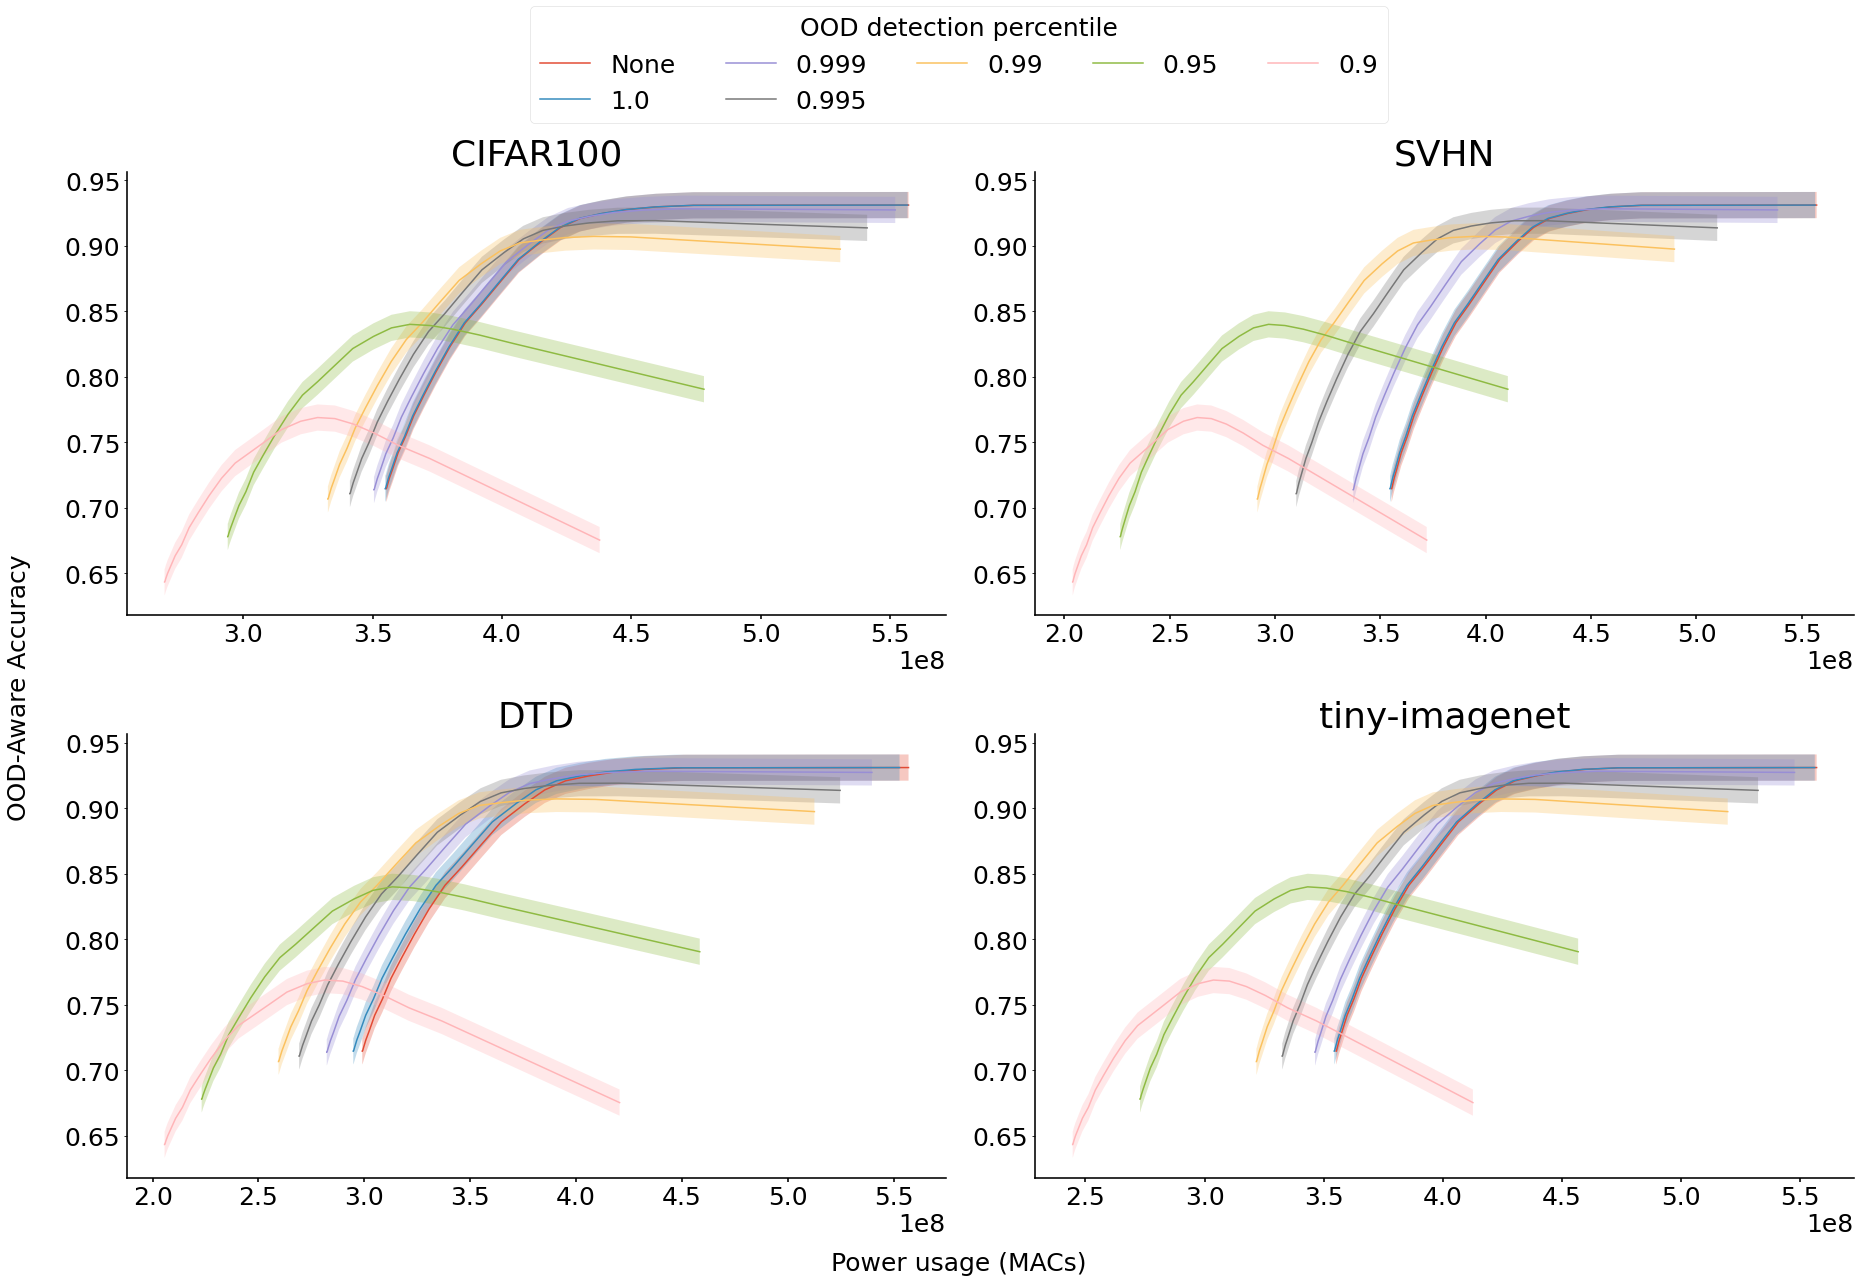

In [9]:
model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/analysis'

fig, axes = plt.subplots(2, int(n_branches/2))
knn_ood_tests = ['CIFAR100','SVHN','DTD','tiny-imagenet']

for data_idx,data_set in enumerate(knn_ood_tests):
    ax = axes.flatten()[data_idx]
    ax.set_title(data_set)
    plot_ood_power(ax,model_directory,'CIFAR10',data_set,n_thresh=25,percentile=1.0,detect_ood=False)
    plot_ood_power(ax,model_directory,'CIFAR10',data_set,n_thresh=25,percentile=1.0,detect_ood=True)
    plot_ood_power(ax,model_directory,'CIFAR10',data_set,n_thresh=25,percentile=0.999)
    plot_ood_power(ax,model_directory,'CIFAR10',data_set,n_thresh=25,percentile=0.995)
    plot_ood_power(ax,model_directory,'CIFAR10',data_set,n_thresh=25,percentile=0.99)
    plot_ood_power(ax,model_directory,'CIFAR10',data_set,n_thresh=25,percentile=0.95)
    plot_ood_power(ax,model_directory,'CIFAR10',data_set,n_thresh=25,percentile=0.9)
    # plt.ylim(0.5,1.0)
    
# plt.ylabel('OOD-Aware Accuracy')
# plt.xlabel('Power usage (MACs)')
h, l = axes.flatten()[-1].get_legend_handles_labels()
legend = fig.legend(h,l,title='OOD detection percentile',loc='center',bbox_to_anchor=(0.5,1.04),ncol=5)
plt.setp(legend.get_title(), multialignment='center')
plt.tight_layout()

# fig.text(0.5, 0.95, ('OOD detection ROC'), ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(-0.01, 0.5, 'OOD-Aware Accuracy', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.0, 'Power usage (MACs)', ha='center', va='center', rotation='horizontal')
plt.savefig('main/figures/ood_powers.pdf',bbox_inches='tight')
plt.show()

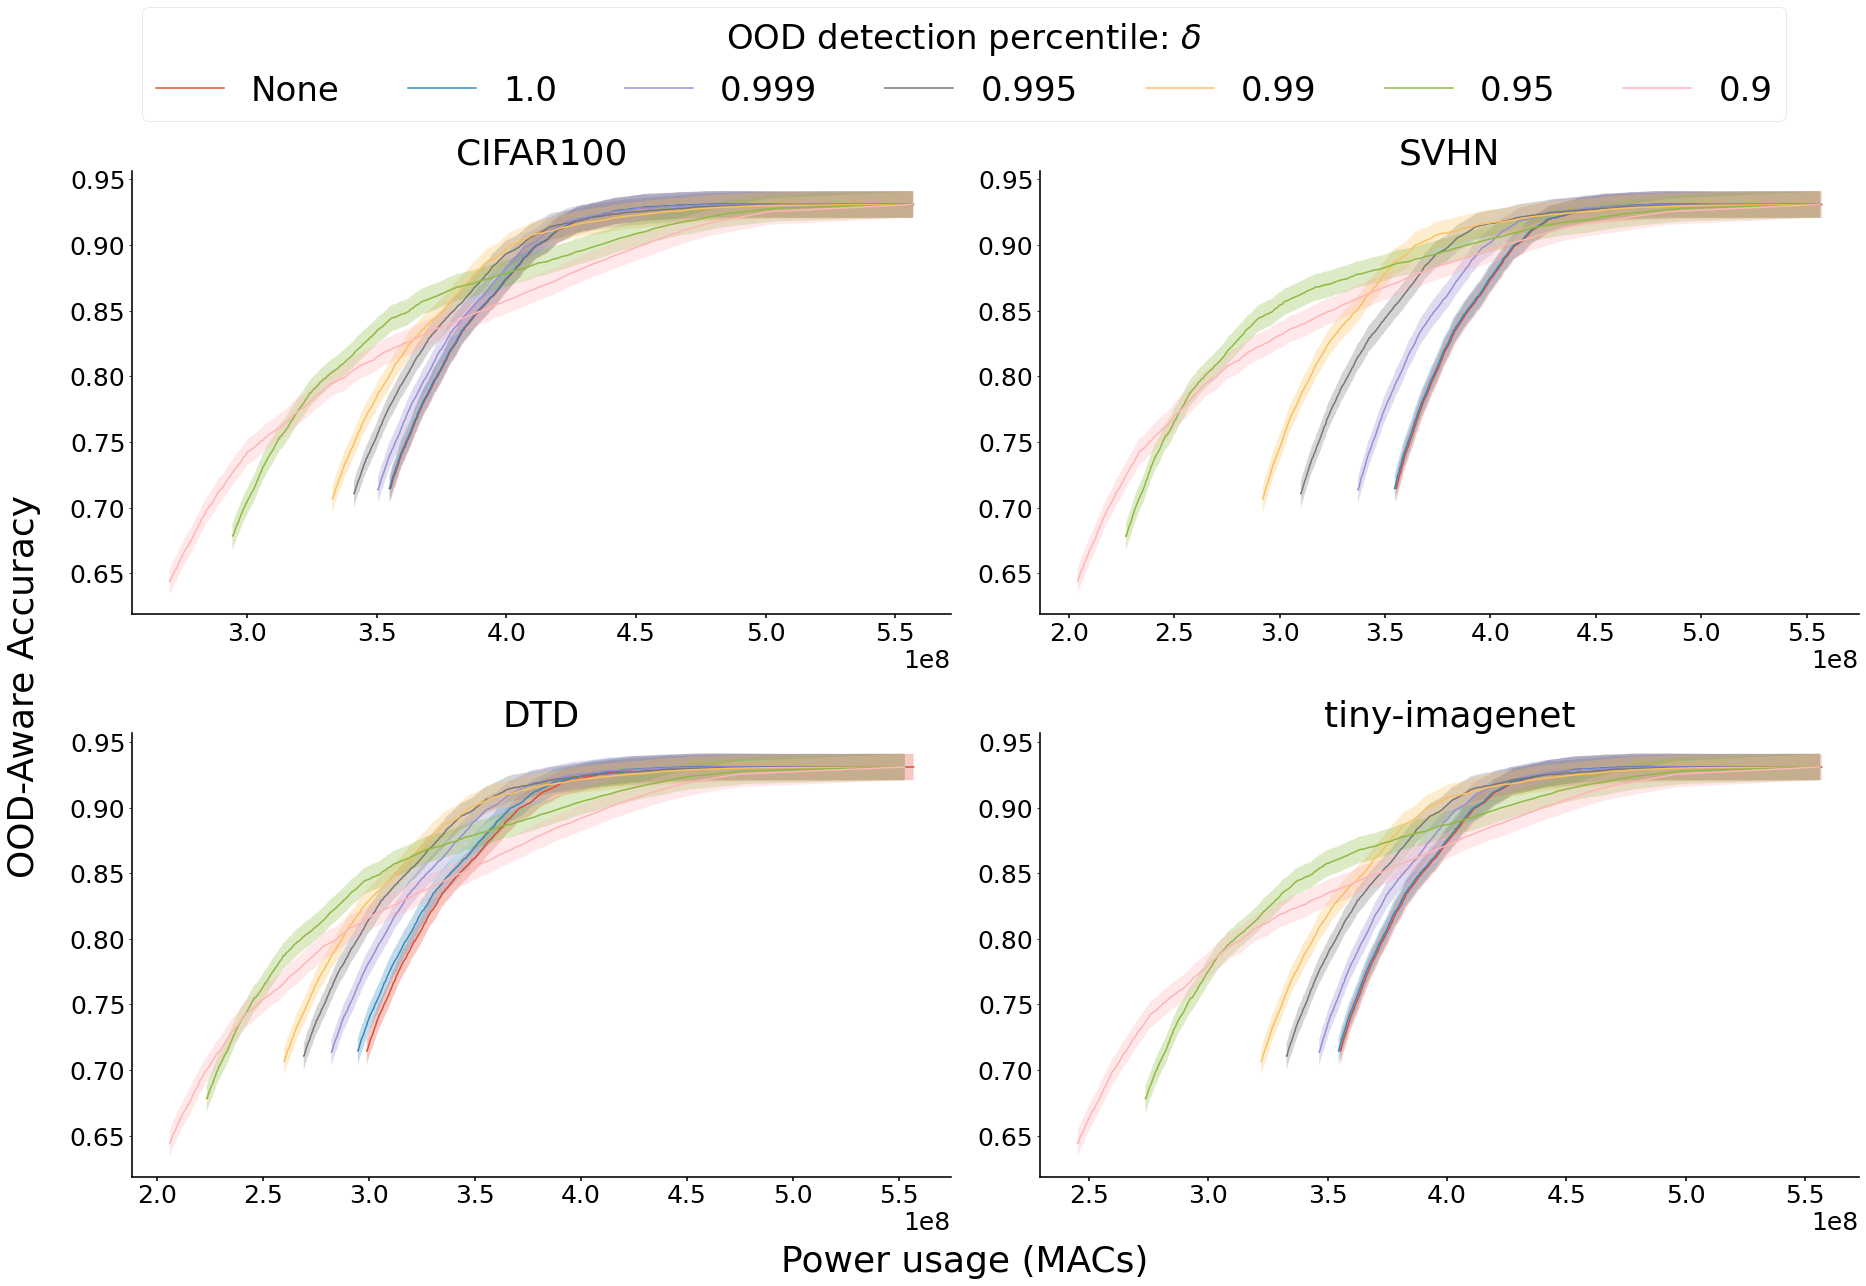

In [10]:
model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/analysis'

fig, axes = plt.subplots(2, int(n_branches/2),figsize=(width,height))
knn_ood_tests = ['CIFAR100','SVHN','DTD','tiny-imagenet']

for data_idx,data_set in enumerate(knn_ood_tests):
    ax = axes.flatten()[data_idx]
    ax.set_title(data_set)
    plot_ood_power(ax,model_directory,'CIFAR10',data_set,n_thresh=250,percentile=1.0,detect_ood=False)
    plot_ood_power(ax,model_directory,'CIFAR10',data_set,n_thresh=250,percentile=1.0,detect_ood=True)
    plot_ood_power(ax,model_directory,'CIFAR10',data_set,n_thresh=250,percentile=0.999,adaptive=True)
    plot_ood_power(ax,model_directory,'CIFAR10',data_set,n_thresh=250,percentile=0.995,adaptive=True)
    plot_ood_power(ax,model_directory,'CIFAR10',data_set,n_thresh=250,percentile=0.99,adaptive=True)
    plot_ood_power(ax,model_directory,'CIFAR10',data_set,n_thresh=250,percentile=0.95,adaptive=True)
    plot_ood_power(ax,model_directory,'CIFAR10',data_set,n_thresh=250,percentile=0.9,adaptive=True)
    # plt.ylim(0.5,1.0)
    
# plt.ylabel('OOD-Aware Accuracy')
# plt.xlabel('Power usage (MACs)')
h, l = axes.flatten()[-1].get_legend_handles_labels()
legend = fig.legend(h,l,title='OOD detection percentile: $\delta$',loc='center',bbox_to_anchor=(0.5,1.04),ncol=7,fontsize=34)
plt.setp(legend.get_title(), multialignment='center',fontsize=34)
plt.tight_layout()

# fig.text(0.5, 0.95, ('OOD detection ROC'), ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(-0.01, 0.5, 'OOD-Aware Accuracy', ha='center', va='center', rotation='vertical',fontsize=36)
fig.text(0.5, 0.0, 'Power usage (MACs)', ha='center', va='center', rotation='horizontal',fontsize=36)
plt.savefig('main/figures/ood_powers_adaptive.pdf',bbox_inches='tight')
plt.show()

/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:168: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:168: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:168: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:168: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:168: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transformer-env/lib/python3.7/site-packages/ipykernel_launcher.py:168: RuntimeWarning: invalid value encountered in sqrt
/home/jd5u19/Progressive Transformers/transfor

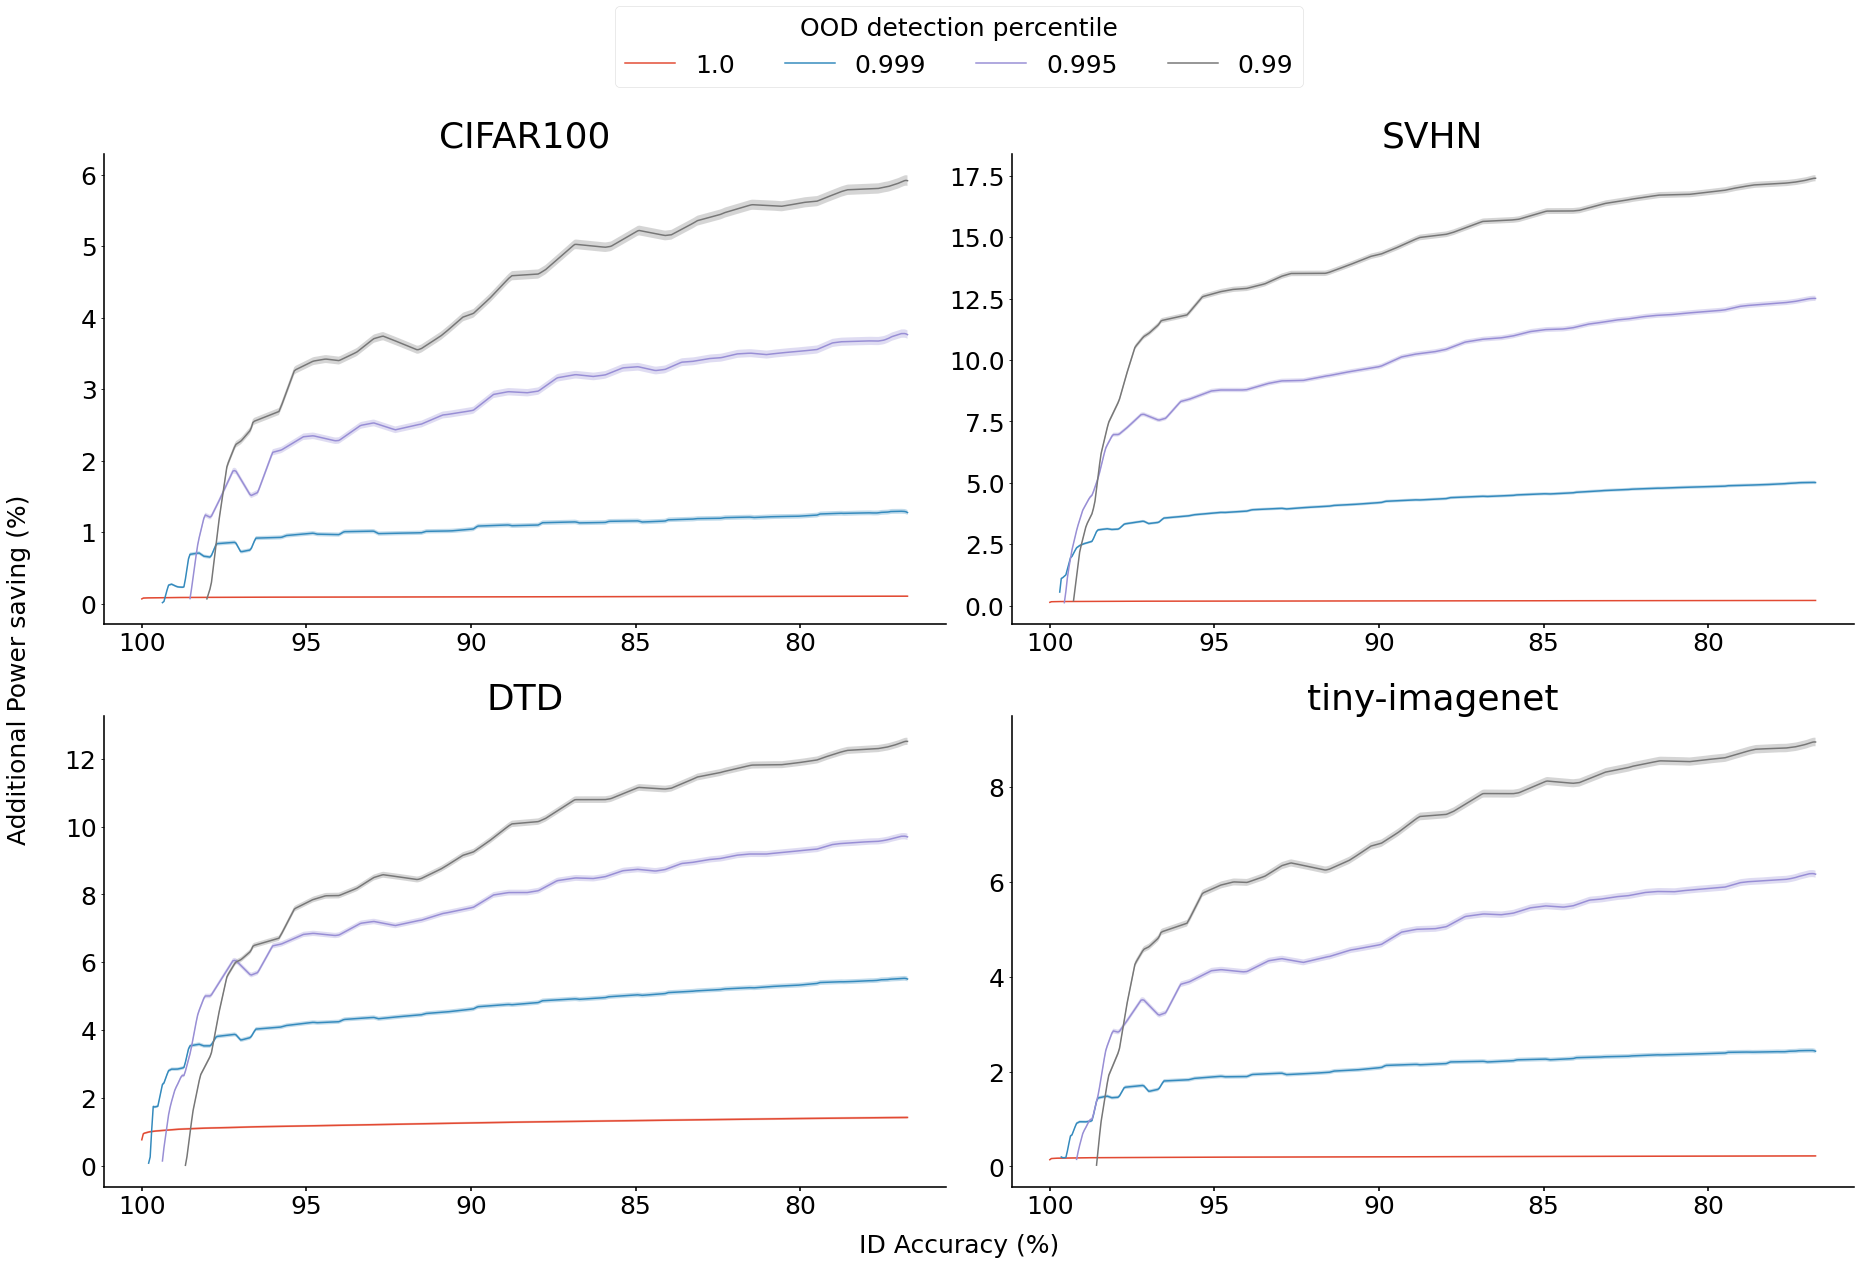

In [11]:
model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/analysis'

fig, axes = plt.subplots(2, int(n_branches/2))
knn_ood_tests = ['CIFAR100','SVHN','DTD','tiny-imagenet']

for data_idx,data_set in enumerate(knn_ood_tests):
    ax = axes.flatten()[data_idx]
    ax.set_title(data_set)
    plot_improvement_power(ax,model_directory,'CIFAR10',data_set,n_thresh=50,percentile=1.0,detect_ood=True)
    plot_improvement_power(ax,model_directory,'CIFAR10',data_set,n_thresh=50,percentile=0.999,adaptive=True)
    plot_improvement_power(ax,model_directory,'CIFAR10',data_set,n_thresh=50,percentile=0.995,adaptive=True)
    plot_improvement_power(ax,model_directory,'CIFAR10',data_set,n_thresh=50,percentile=0.99,adaptive=True)
    ax.invert_xaxis()
    
# plt.ylabel('OOD-Aware Accuracy')
# plt.xlabel('Power usage (MACs)')
h, l = axes.flatten()[-1].get_legend_handles_labels()
legend = fig.legend(h,l,title='OOD detection percentile',loc='center',bbox_to_anchor=(0.5,1.04),ncol=5)
plt.setp(legend.get_title(), multialignment='center')
plt.tight_layout()

# fig.text(0.5, 0.95, ('OOD detection ROC'), ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(0.5, 0.00, 'ID Accuracy (%)', ha='center', va='center', rotation='horizontal')
fig.text(-0.01, 0.5, 'Additional Power saving (%)', ha='center', va='center', rotation='vertical')
plt.savefig('main/figures/power_improvement.pdf',bbox_inches='tight')
plt.show()

In [6]:
def plot_ood_accuracy(ax,model_directory,data,ood_data,n_thresh,percentile,detect_ood=True,adaptive=False):
    base_value_dict = run_ood_inference(model_directory,data,ood_data,n_thresh=n_thresh,knn_percentile=1.0,detect_ood=False,adaptive=False)
    base_acc=base_value_dict['id_accuracy']

    func_out = run_ood_inference(model_directory,data,ood_data,n_thresh=n_thresh,knn_percentile=percentile,detect_ood=detect_ood,adaptive=adaptive)
    id_acc,ood_acc=func_out['id_accuracy'],func_out['ood_accuracy']
    
    acc_range = np.linspace(min(base_acc),max(base_acc),500)

    max_acc = max(base_acc)

    label = str(percentile)
    if adaptive:
        label = label + ' adaptive'

    interp_ood_acc_test = np.interp(acc_range,id_acc,ood_acc)*100

    acc_range = (acc_range/max_acc)*100
    
    ax.plot(acc_range,interp_ood_acc_test,label=label)

    sigma=3
    interval = sigma*np.sqrt(interp_ood_acc_test/func_out['n_id_samples'])

    ax.fill_between(acc_range,interp_ood_acc_test-interval,interp_ood_acc_test+interval,alpha=0.3)

    targets = np.array([100,99,95,90])
    key_indices = list()

    for target in targets:
        key_indices.append(np.abs(acc_range - target).argmin())

    
    return np.round(acc_range[key_indices],0),np.round(interp_ood_acc_test[key_indices],2)

CIFAR100
1.0 (array([100.,  99.,  95.,  90.]), array([0.42, 0.42, 0.42, 0.42]))
0.999 (array([100.,  99.,  95.,  90.]), array([0.42, 4.57, 5.67, 5.87]))
0.995 (array([100.,  99.,  95.,  90.]), array([ 0.42, 10.76, 15.39, 16.74]))
0.99 (array([100.,  99.,  95.,  90.]), array([ 0.42, 13.87, 23.01, 24.96]))
0.95 (array([100.,  99.,  95.,  90.]), array([ 0.42, 13.13, 41.08, 55.42]))
0.9 (array([100.,  99.,  95.,  90.]), array([ 0.42, 10.35, 39.37, 61.88]))
SVHN
1.0 (array([100.,  99.,  95.,  90.]), array([0.57, 0.57, 0.57, 0.57]))
0.999 (array([100.,  99.,  95.,  90.]), array([ 0.57, 10.44, 12.51, 13.31]))
0.995 (array([100.,  99.,  95.,  90.]), array([ 0.57, 22.14, 31.09, 32.84]))
0.99 (array([100.,  99.,  95.,  90.]), array([ 0.57, 28.46, 45.81, 48.32]))
0.95 (array([100.,  99.,  95.,  90.]), array([ 0.57, 26.13, 70.67, 84.73]))
0.9 (array([100.,  99.,  95.,  90.]), array([ 0.57, 19.64, 68.76, 88.91]))
DTD
1.0 (array([100.,  99.,  95.,  90.]), array([4.96, 4.96, 4.96, 4.96]))
0.999 (arra

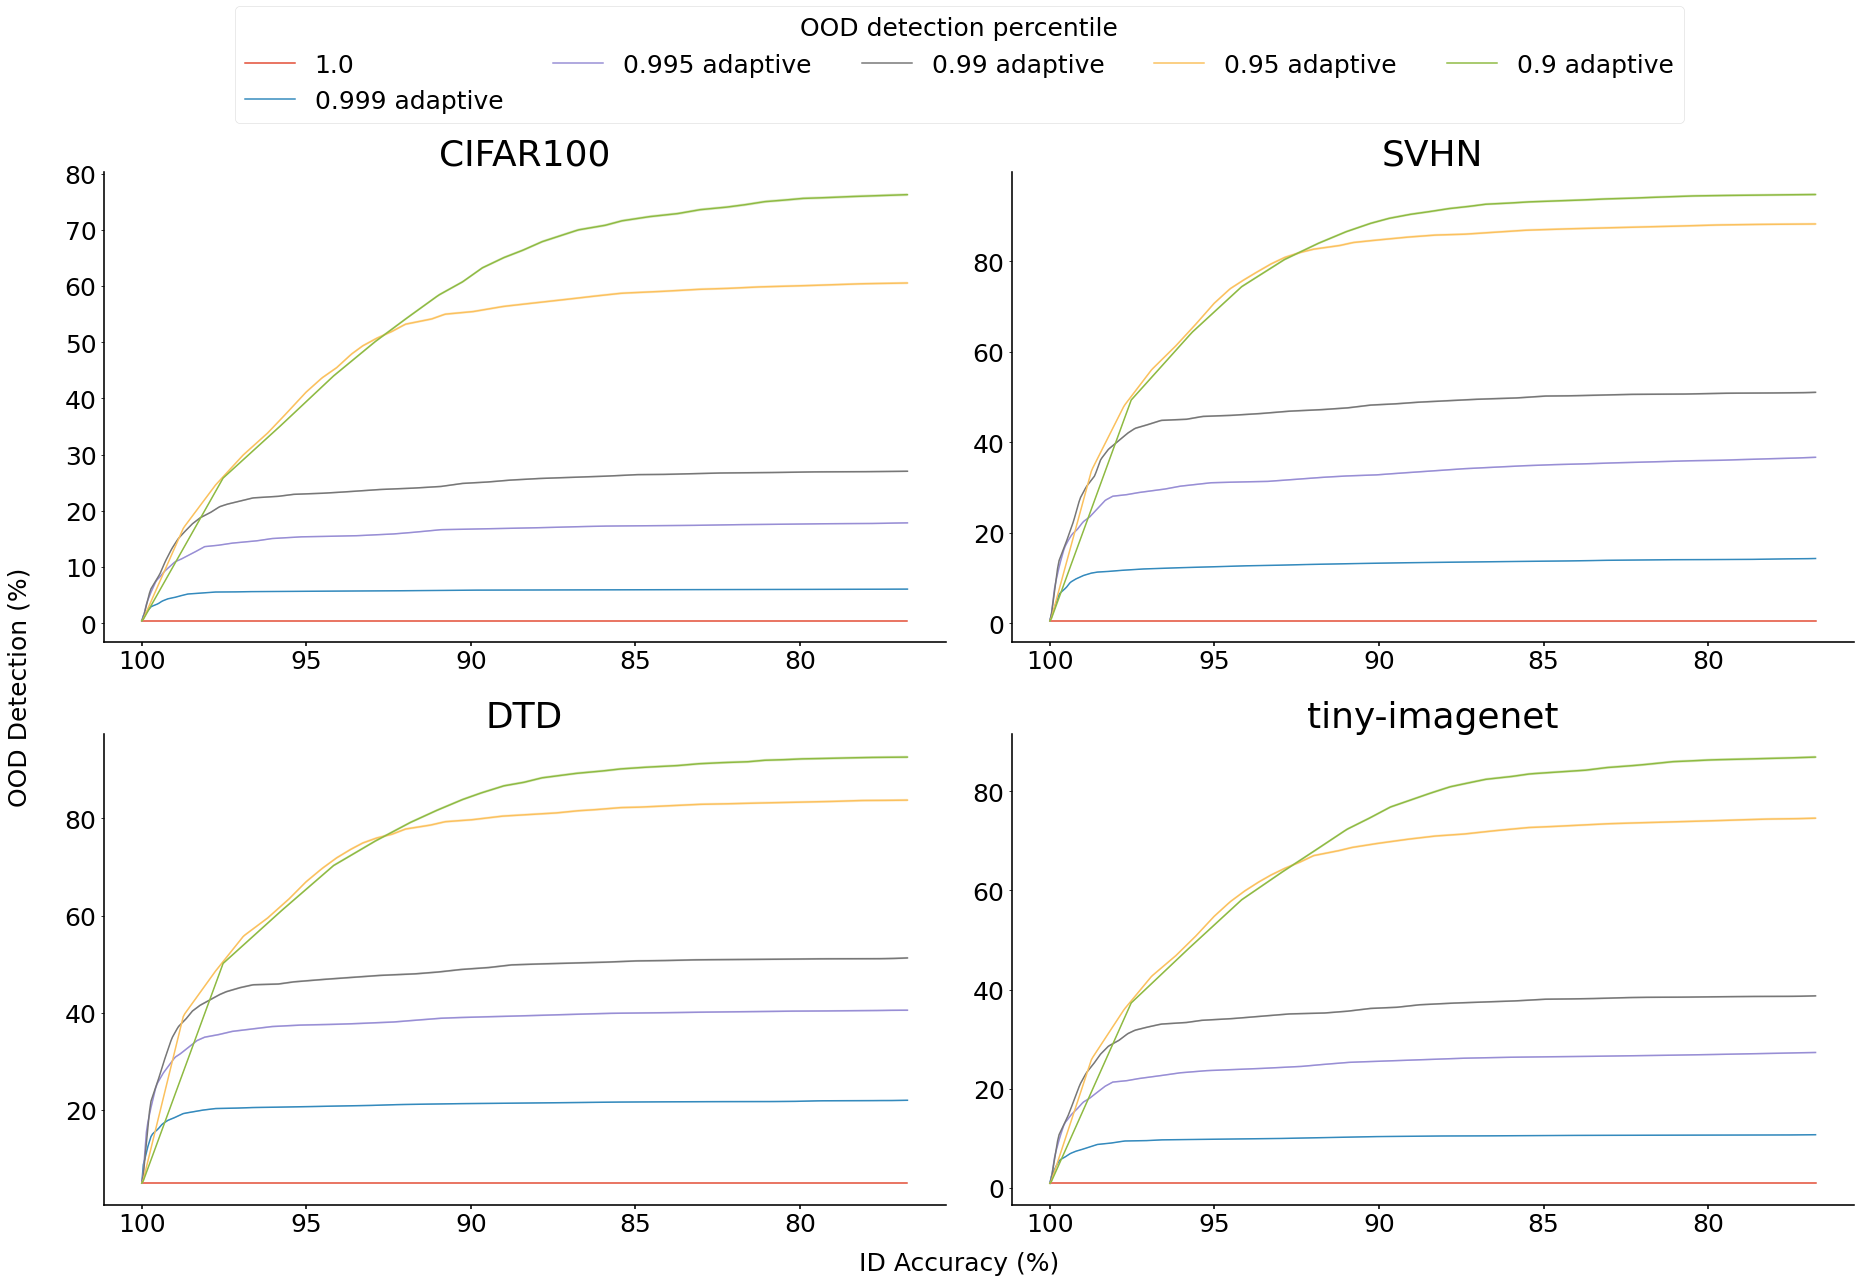

In [13]:
model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/analysis'

fig, axes = plt.subplots(2, int(n_branches/2))
knn_ood_tests = ['CIFAR100','SVHN','DTD','tiny-imagenet']

for data_idx,data_set in enumerate(knn_ood_tests):
    ax = axes.flatten()[data_idx]
    ax.set_title(data_set)
    print(data_set)
    print(1.0,plot_ood_accuracy(ax,model_directory,'CIFAR10',data_set,n_thresh=50,percentile=1.0,detect_ood=True))
    print(0.999,plot_ood_accuracy(ax,model_directory,'CIFAR10',data_set,n_thresh=50,percentile=0.999,adaptive=True))
    print(0.995,plot_ood_accuracy(ax,model_directory,'CIFAR10',data_set,n_thresh=50,percentile=0.995,adaptive=True))
    print(0.99,plot_ood_accuracy(ax,model_directory,'CIFAR10',data_set,n_thresh=50,percentile=0.99,adaptive=True))
    print(0.95,plot_ood_accuracy(ax,model_directory,'CIFAR10',data_set,n_thresh=50,percentile=0.95,adaptive=True))
    print(0.90,plot_ood_accuracy(ax,model_directory,'CIFAR10',data_set,n_thresh=50,percentile=0.90,adaptive=True))
    ax.invert_xaxis()
    
# plt.ylabel('OOD-Aware Accuracy')
# plt.xlabel('Power usage (MACs)')
h, l = axes.flatten()[-1].get_legend_handles_labels()
legend = fig.legend(h,l,title='OOD detection percentile',loc='center',bbox_to_anchor=(0.5,1.04),ncol=5)
plt.setp(legend.get_title(), multialignment='center')
plt.tight_layout()

# fig.text(0.5, 0.95, ('OOD detection ROC'), ha='center', va='center', rotation='horizontal',fontsize=30)
fig.text(0.5, 0.00, 'ID Accuracy (%)', ha='center', va='center', rotation='horizontal')
fig.text(-0.01, 0.5, 'OOD Detection (%)', ha='center', va='center', rotation='vertical')
plt.savefig('main/figures/ood_accuracy.pdf',bbox_inches='tight')
plt.show()

In [7]:
def get_metrics_accuracy(model_directory,data,ood_data,n_thresh,percentile,detect_ood=True,adaptive=False,verbose=True):
    base_value_dict = run_ood_inference(model_directory,data,ood_data,n_thresh=n_thresh,knn_percentile=1.0,detect_ood=False,adaptive=False)
    base_acc=base_value_dict['id_accuracy']
    base_powers=base_value_dict['power_usage']

    min_power = base_powers[0]
    min_power_acc = base_acc[0]

    func_out = run_ood_inference(model_directory,data,ood_data,n_thresh=n_thresh,knn_percentile=percentile,detect_ood=detect_ood,adaptive=adaptive)
    ood_powers,ood_acc=func_out['power_usage'],func_out['id_accuracy']
    
    #accuracy increase
    equiv_idx = np.argmin(np.abs(ood_powers-min_power))
    peak_accuracy_gain = (ood_acc[equiv_idx]-min_power_acc)*100

    #power increase      
    max_power_idx = np.argmax(base_powers - ood_powers)
    peak_power_gain = ((base_powers[max_power_idx] - ood_powers[max_power_idx])/base_powers[max_power_idx])*100

    if verbose:
        print('peak accuracy increase: ',np.round(peak_accuracy_gain,4))
        print('peak power increase: ',np.round(peak_power_gain,4))

    return(peak_accuracy_gain,peak_power_gain)

In [15]:
model_directory = 'trained-models/CIFAR10/resnet_4_branch/w1.0_d18/300-epoch/analysis'

knn_ood_tests = ['CIFAR100','SVHN','DTD','tiny-imagenet']
percentiles = [1.0,0.999,0.995,0.99,0.95,0.9]

for data_idx,data_set in enumerate(knn_ood_tests):
    print('\n',data_set)
    for percentile in percentiles:
        print(percentile)
        get_metrics_accuracy(model_directory,'CIFAR10',data_set,n_thresh=50,percentile=percentile,detect_ood=True)


 CIFAR100
1.0
peak accuracy increase:  0.17
peak power increase:  0.094
0.999
peak accuracy increase:  2.47
peak power increase:  0.9218
0.995
peak accuracy increase:  6.37
peak power increase:  2.8694
0.99
peak accuracy increase:  9.32
peak power increase:  4.7327
0.95
peak accuracy increase:  12.18
peak power increase:  14.1837
0.9
peak accuracy increase:  3.69
peak power increase:  21.4195

 SVHN
1.0
peak accuracy increase:  0.54
peak power increase:  0.2081
0.999
peak accuracy increase:  8.44
peak power increase:  3.3338
0.995
peak accuracy increase:  15.32
peak power increase:  8.4716
0.99
peak accuracy increase:  17.94
peak power increase:  12.1207
0.95
peak accuracy increase:  10.51
peak power increase:  26.31
0.9
peak accuracy increase:  -3.92
peak power increase:  33.2221

 DTD
1.0
peak accuracy increase:  1.87
peak power increase:  1.4227
0.999
peak accuracy increase:  6.76
peak power increase:  3.1046
0.995
peak accuracy increase:  9.86
peak power increase:  5.8006
0.99
pea

In [11]:
directories = ['trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch/analysis',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_1/analysis',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_2/analysis',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_3/analysis',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_4/analysis']
               
knn_ood_tests = ['CIFAR10','SVHN','DTD','tiny-imagenet']
percentiles = [1.0,0.999,0.995,0.99,0.95,0.9]

all_values = np.zeros((len(directories),len(knn_ood_tests),len(percentiles),2))

for dir_index,directory in enumerate(directories):
    print('in directory:',directory)
    for data_idx,data_set in enumerate(knn_ood_tests):
        print('\n',data_set)
        for p_index,percentile in enumerate(percentiles):
            print(percentile)
            acc,pow = get_metrics_accuracy(directory,'CIFAR100',data_set,n_thresh=50,percentile=percentile,detect_ood=True,verbose=False)

            all_values[dir_index,data_idx,p_index,0] = acc
            all_values[dir_index,data_idx,p_index,1] = pow

np.save(directories[0]+'/peak_values_multirun_ood.npy',all_values) 

in directory: trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch/analysis

 CIFAR10
1.0
0.999
0.995
0.99
0.95
0.9

 SVHN
1.0
0.999
0.995
0.99
0.95
0.9

 DTD
1.0
0.999
0.995
0.99
0.95
0.9

 tiny-imagenet
1.0
0.999
0.995
0.99
0.95
0.9
in directory: trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_1/analysis

 CIFAR10
1.0
0.999
0.995
0.99
0.95
0.9

 SVHN
1.0
0.999
0.995
0.99
0.95
0.9

 DTD
1.0
0.999
0.995
0.99
0.95
0.9

 tiny-imagenet
1.0
0.999
0.995
0.99
0.95
0.9
in directory: trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_2/analysis

 CIFAR10
1.0
0.999
0.995
0.99
0.95
0.9

 SVHN
1.0
0.999
0.995
0.99
0.95
0.9

 DTD
1.0
0.999
0.995
0.99
0.95
0.9

 tiny-imagenet
1.0
0.999
0.995
0.99
0.95
0.9
in directory: trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_3/analysis

 CIFAR10
1.0
0.999
0.995
0.99
0.95
0.9

 SVHN
1.0
0.999
0.995
0.99
0.95
0.9

 DTD
1.0
0.999
0.995
0.99
0.95
0.9

 tiny-imagenet
1.0
0.999
0.995
0.99
0.95
0.9
in directory: trained-models/C

In [12]:
directory = 'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch/analysis'

all_vals = np.load(directory+'/peak_values_multirun_ood.npy')

knn_ood_tests = ['CIFAR10','SVHN','DTD','tiny-imagenet']
percentiles = [1.0,0.999,0.995,0.99,0.95,0.9]

for data_idx,data_set in enumerate(knn_ood_tests):
    print('\n',data_set)
    for p_index,percentile in enumerate(percentiles):
        mean_acc = np.mean(all_vals[:,data_idx,p_index,0])
        std_acc = np.std(all_vals[:,data_idx,p_index,0])

        mean_power = np.mean(all_vals[:,data_idx,p_index,1])
        std_power = np.std(all_vals[:,data_idx,p_index,1])
        print(percentile,'\tacc:',np.round(mean_acc,2),'+-',np.round(std_acc,2))
        print(percentile,'\tpower:',np.round(mean_power,2),'+-',np.round(std_power,2))


 CIFAR10
1.0 	acc: 0.01 +- 0.01
1.0 	power: 0.02 +- 0.01
0.999 	acc: 0.23 +- 0.08
0.999 	power: 0.17 +- 0.01
0.995 	acc: 0.97 +- 0.03
0.995 	power: 0.91 +- 0.05
0.99 	acc: 1.99 +- 0.32
0.99 	power: 1.74 +- 0.06
0.95 	acc: 7.39 +- 0.74
0.95 	power: 7.86 +- 0.23
0.9 	acc: 9.92 +- 0.33
0.9 	power: 14.55 +- 0.3

 SVHN
1.0 	acc: 0.0 +- 0.0
1.0 	power: 0.01 +- 0.01
0.999 	acc: 0.57 +- 0.43
0.999 	power: 0.41 +- 0.26
0.995 	acc: 3.49 +- 1.6
0.995 	power: 1.84 +- 0.71
0.99 	acc: 5.34 +- 2.45
0.99 	power: 3.31 +- 1.01
0.95 	acc: 14.74 +- 1.94
0.95 	power: 12.63 +- 1.23
0.9 	acc: 16.76 +- 2.16
0.9 	power: 22.55 +- 1.88

 DTD
1.0 	acc: 0.31 +- 0.15
1.0 	power: 0.4 +- 0.18
0.999 	acc: 2.51 +- 0.22
0.999 	power: 1.66 +- 0.17
0.995 	acc: 6.26 +- 0.22
0.995 	power: 4.1 +- 0.37
0.99 	acc: 8.31 +- 0.55
0.99 	power: 5.99 +- 0.32
0.95 	acc: 12.54 +- 0.88
0.95 	power: 14.14 +- 0.63
0.9 	acc: 11.81 +- 0.46
0.9 	power: 20.64 +- 0.69

 tiny-imagenet
1.0 	acc: 0.02 +- 0.03
1.0 	power: 0.02 +- 0.02
0.999 	acc

Directory: trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch/analysis
Dataset: CIFAR10
1.0 [100.  99.  95.  90.] [0.12 0.12 0.12 0.12]
0.999 [100.  99.  95.  90.] [0.12 0.5  0.66 0.7 ]
0.995 [100.  99.  95.  90.] [0.12 1.62 2.49 2.81]
0.99 [100.  99.  95.  90.] [0.12 2.5  4.27 5.08]
0.95 [100.  99.  95.  90.] [ 0.12  2.34 12.13 18.98]
0.9 [100.  99.  95.  90.] [ 0.12  2.35 11.15 22.97]
Dataset: SVHN
1.0 [100.  99.  95.  90.] [0.13 0.13 0.13 0.13]
0.999 [100.  99.  95.  90.] [0.13 0.99 1.28 1.38]
0.995 [100.  99.  95.  90.] [0.13 3.6  5.49 6.45]
0.99 [100.  99.  95.  90.] [ 0.13  5.44  9.44 11.74]
0.95 [100.  99.  95.  90.] [ 0.13  5.11 31.58 47.39]
0.9 [100.  99.  95.  90.] [ 0.13  5.33 29.15 55.76]
Dataset: DTD
1.0 [100.  99.  95.  90.] [1.74 1.74 1.74 1.74]
0.999 [100.  99.  95.  90.] [ 1.74 11.47 13.99 14.63]
0.995 [100.  99.  95.  90.] [ 1.74 23.3  27.98 29.64]
0.99 [100.  99.  95.  90.] [ 1.74 27.82 35.81 38.58]
0.95 [100.  99.  95.  90.] [ 1.74 22.39 54.64 65.22]
0.9 [10

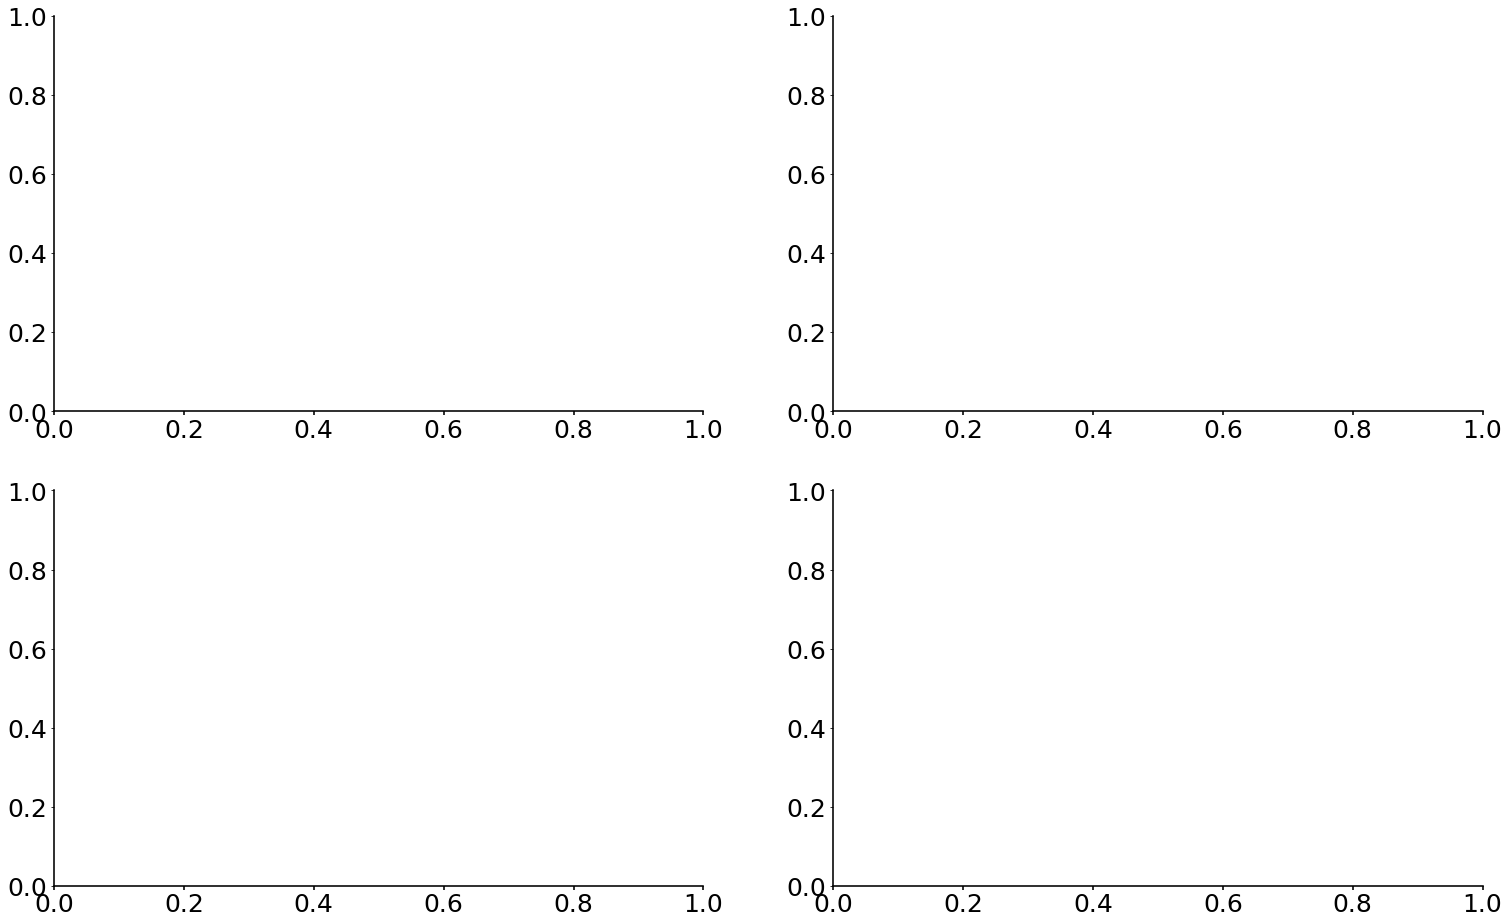

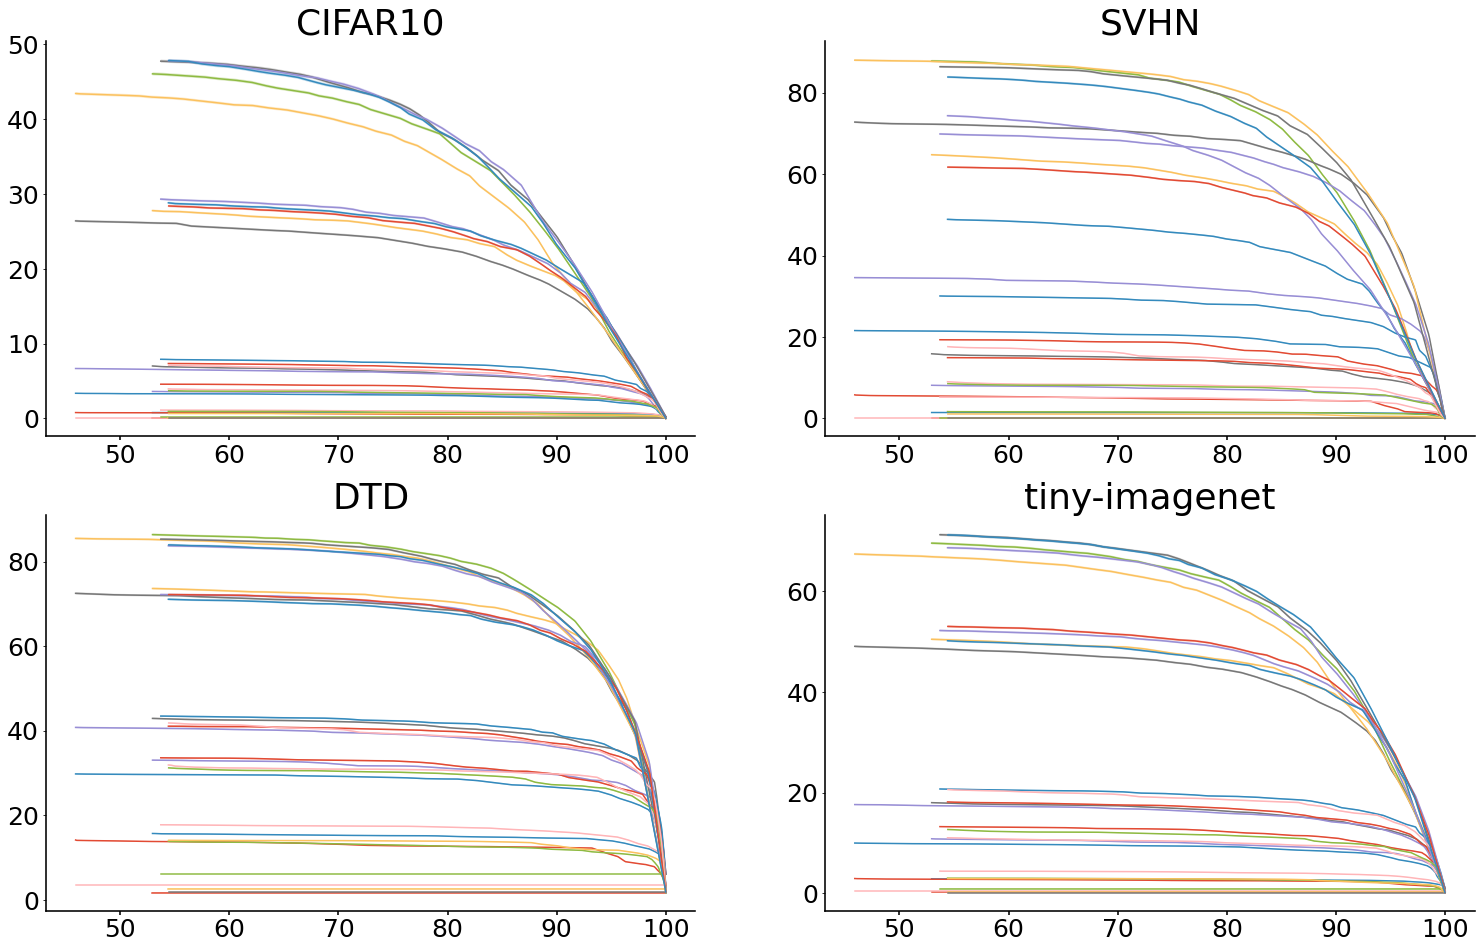

In [13]:
directories = ['trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch/analysis',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_1/analysis',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_2/analysis',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_3/analysis',
               'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch_4/analysis']

n_branches=4
fig, axes = plt.subplots(2, int(n_branches/2))
knn_ood_tests = ['CIFAR10','SVHN','DTD','tiny-imagenet']
percentiles = [1.0,0.999,0.995,0.99,0.95,0.9]
detection_values = np.zeros((len(directories),len(knn_ood_tests),len(percentiles),4))

fig, axes = plt.subplots(2, int(n_branches/2))
for dir_idx,directory in enumerate(directories):
    print('Directory:',directory)
    for data_idx,data_set in enumerate(knn_ood_tests):
        print('Dataset:',data_set)
        ax = axes.flatten()[data_idx]
        ax.set_title(data_set)
        for p_index,percentile in enumerate(percentiles):
            accs,detect_accs = plot_ood_accuracy(ax,directory,'CIFAR100',data_set,n_thresh=50,percentile=percentile,detect_ood=True,adaptive=True)
            print(percentile,accs,detect_accs)
            detection_values[dir_idx,data_idx,p_index,:] = detect_accs
            
np.save(directories[0]+'/detection_accuracies_ood.npy',detection_values) 

In [14]:
directory = 'trained-models/CIFAR100/resnet_4_branch/w1.0_d18/300-epoch/analysis'

detection_accuracies_ood = np.load(directory+'/detection_accuracies_ood.npy')

knn_ood_tests = ['CIFAR10','SVHN','DTD','tiny-imagenet']
percentiles = [1.0,0.999,0.995,0.99,0.95,0.9]

targets = np.array([100,99,95,90])

for data_idx,data_set in enumerate(knn_ood_tests):
    print('\n',data_set)
    for t_index, target in enumerate(targets):
        print('target',target)
        for p_index,percentile in enumerate(percentiles):
            acc_mean = np.mean(detection_accuracies_ood[:,data_idx,p_index,t_index])
            acc_std =  np.std(detection_accuracies_ood[:,data_idx,p_index,t_index])
            print(percentile,'\tacc:',np.round(acc_mean,2),'+-',np.round(acc_std,2))


 CIFAR10
target 100
1.0 	acc: 0.09 +- 0.08
0.999 	acc: 0.09 +- 0.08
0.995 	acc: 0.09 +- 0.08
0.99 	acc: 0.09 +- 0.08
0.95 	acc: 0.09 +- 0.08
0.9 	acc: 0.09 +- 0.08
target 99
1.0 	acc: 0.09 +- 0.08
0.999 	acc: 0.39 +- 0.12
0.995 	acc: 1.53 +- 0.12
0.99 	acc: 2.19 +- 0.31
0.95 	acc: 2.41 +- 0.3
0.9 	acc: 2.42 +- 0.21
target 95
1.0 	acc: 0.09 +- 0.08
0.999 	acc: 0.58 +- 0.15
0.995 	acc: 2.59 +- 0.24
0.99 	acc: 4.63 +- 0.41
0.95 	acc: 11.87 +- 0.74
0.9 	acc: 11.67 +- 0.66
target 90
1.0 	acc: 0.09 +- 0.08
0.999 	acc: 0.65 +- 0.14
0.995 	acc: 3.06 +- 0.33
0.99 	acc: 5.5 +- 0.5
0.95 	acc: 19.13 +- 1.01
0.9 	acc: 22.9 +- 1.5

 SVHN
target 100
1.0 	acc: 0.08 +- 0.04
0.999 	acc: 0.08 +- 0.04
0.995 	acc: 0.08 +- 0.04
0.99 	acc: 0.08 +- 0.04
0.95 	acc: 0.08 +- 0.04
0.9 	acc: 0.08 +- 0.04
target 99
1.0 	acc: 0.08 +- 0.04
0.999 	acc: 0.97 +- 0.46
0.995 	acc: 5.43 +- 2.9
0.99 	acc: 7.35 +- 3.43
0.95 	acc: 8.3 +- 3.86
0.9 	acc: 7.47 +- 2.7
target 95
1.0 	acc: 0.08 +- 0.04
0.999 	acc: 1.91 +- 1.18
0.9